# What makes people happy?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nelsonlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
demo = pd.read_csv("../data/demographic.csv")
hm = pd.read_csv("../output/processed_moments.csv")
print(demo.shape)
demo.head()

(10844, 6)


,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


In [3]:
print(hm.shape)
hm.head()

(100392, 11)


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,id,text
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,1,successfully date sympathy connected
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection,2,son marks examination
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise,3,gym morning yoga
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding,4,talked friend flaky understood evening hang
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection,5,grandchildren butterfly display crohn conserva...


hmid (int): Happy moment ID  
wid (int): Worker ID  
reflection_period (str): Reflection period used in the instructions provided to the worker (3m or 24h)  
original_hm (str): Original happy moment  
cleaned_hm (str): Cleaned happy moment  
modified (bool): If True, original_hm is "cleaned up" to generate cleaned_hm (True or False)  
predicted_category (str): Happiness category label predicted by our classifier (7 categories. Please see the reference for details)  
ground_truth_category (str): Ground truth category label. The value is NaN if the ground truth label is missing for the happy moment  
num_sentence (int): Number of sentences in the happy moment  

How many had to be modified?

In [6]:
np.sum(hm.modified)

98186

#### Let's merge the data sets

In [4]:
data = pd.merge(hm, demo, on = "wid")
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,id,text,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,1,successfully date sympathy connected,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,201,played game fun enjoyed mechanical,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,401,listening music heard entire album hadnt heard,35,USA,m,single,n
3,33522,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1,NaN,bonding,5804,movie friend,35,USA,m,single,n
4,34522,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1,NaN,leisure,6802,played guitar learned song,35,USA,m,single,n


Now how many have null values

In [8]:
data.isnull().sum()

hmid                         0
wid                          0
reflection_period            0
original_hm                  0
cleaned_hm                   0
modified                     0
num_sentence                 0
ground_truth_category    86285
predicted_category           0
id                           0
text                         1
age                         93
country                    203
gender                      79
marital                    157
parenthood                  78
dtype: int64

Out of 10k samples, up to 2% of the data is missing for each category. We can drop nan from the categories when doing analysis. Not sure why there's a missing text, that should get removed all together

In [5]:
data = data[pd.notnull(data['text'])]

#### Who are our posters? Checking to see imbalanced data sets

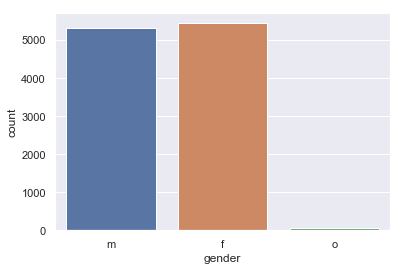

In [6]:
sns.set(style="darkgrid")
sns.countplot(x="gender", data=demo)

Even split in gender, although "other" is a very small proportion of the data set. Will likely need to use with recall/precision/F1.

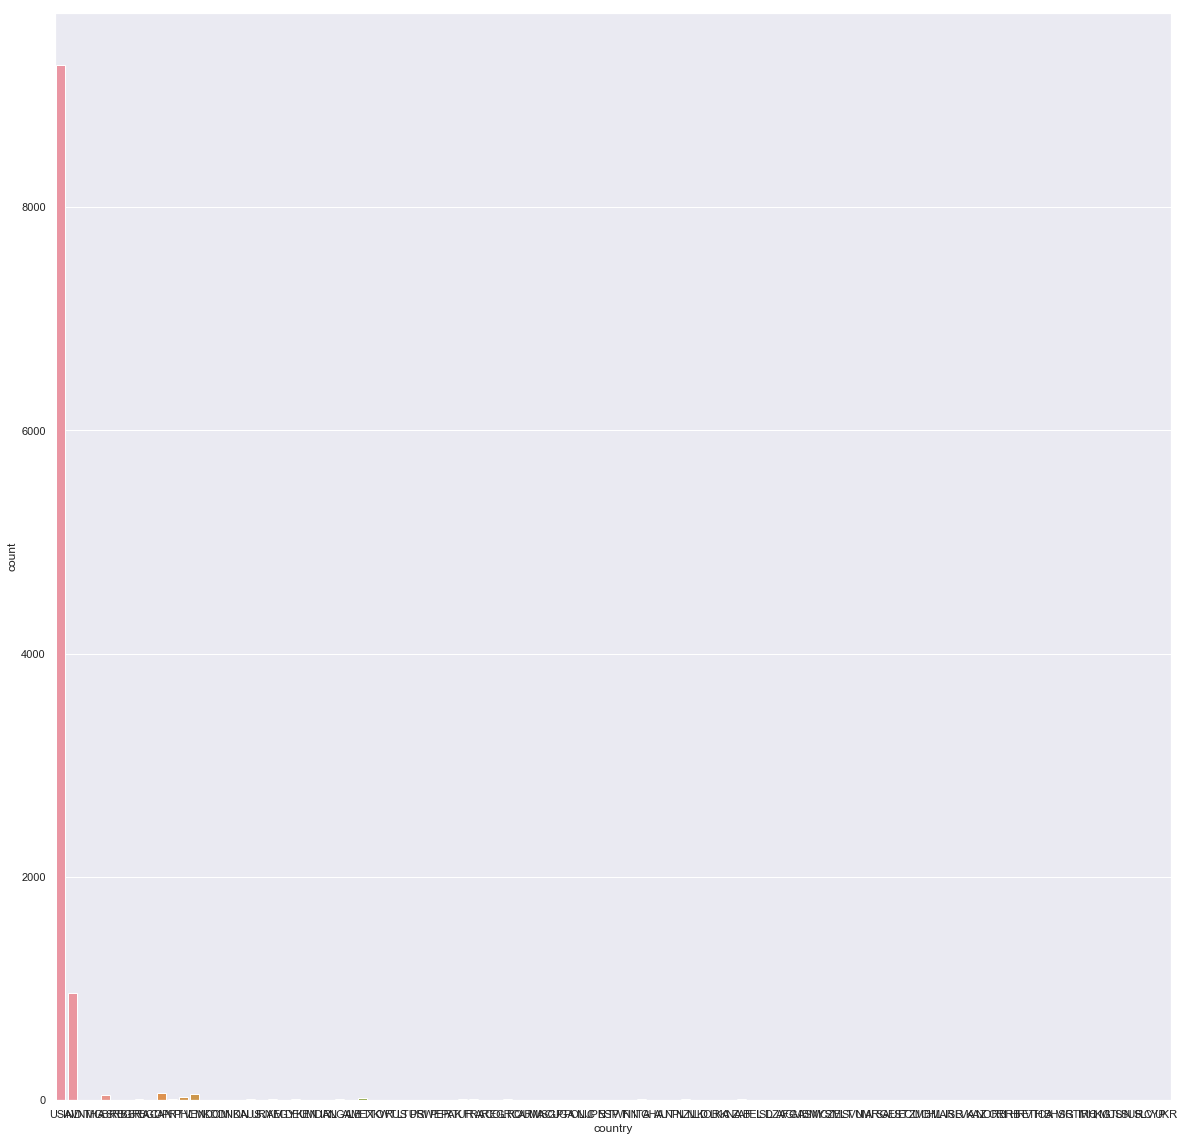

In [62]:
plt.figure(figsize = (20,20))
sns.countplot(x="country", data=demo)

In [63]:
demo.country.unique()

array(['USA', 'IND', 'VNM', 'THA', 'GBR', 'SRB', 'BGR', 'BRA', 'BGD',
       'CAN', 'PRT', 'PHL', 'VEN', 'MKD', 'DOM', 'DNK', 'IDN', 'AUS',
       'URY', 'JAM', 'EGY', 'DEU', 'KEN', 'MDA', 'IRL', 'NGA', 'ALB',
       'MEX', 'TTO', 'KWT', 'RUS', 'LTU', 'PRI', 'SWE', 'PER', 'PAK',
       'TUR', 'FRA', 'ARE', 'COL', 'GRC', 'ROU', 'ARM', 'MAC', 'SGP',
       'UGA', 'POL', 'NIC', 'JPN', 'ESP', 'TWN', 'FIN', 'ITA', 'GHA',
       'AUT', 'NPL', 'NZL', 'NLD', 'KOR', 'LKA', 'KNA', 'ZAF', 'BEL',
       'ISL', 'DZA', 'AFG', 'GMB', nan, 'ASM', 'MYS', 'CZE', 'MLT', 'SVN',
       'UMI', 'ARG', 'SAU', 'EST', 'ECU', 'ZMB', 'CHL', 'MAR', 'ISR',
       'LVA', 'KAZ', 'NOR', 'CRI', 'BRB', 'HRV', 'ETH', 'TCA', 'BHS',
       'VIR', 'GTM', 'IRQ', 'HKG', 'MUS', 'TUN', 'SUR', 'SLV', 'CYP',
       'UKR'], dtype=object)

Overwhelmingly American and Indian, will transform to binary variable

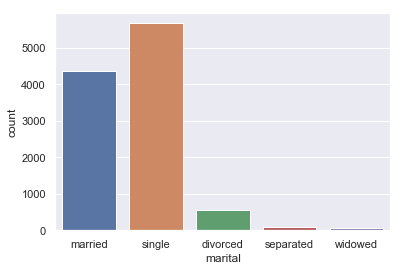

In [64]:
sns.countplot(x="marital", data=demo)

Maybe I can see the difference in happiness single people have to the other categories. May combine divorced/separated/widowed into the same category.

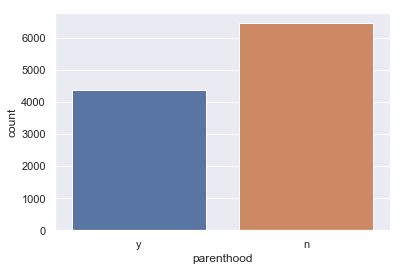

In [65]:
sns.countplot(x="parenthood", data=demo)

Many more kidless than with kids.

Cleaning up this data

In [66]:
demo.age.unique()

array(['37.0', '29.0', '25', '32', '29', '35', '34', '61', '27', '45.0',
       '25.0', '35.0', '30.0', '30', '40', '32.0', '31.0', '28', '36.0',
       '44', '31', '23', '26', '37', '36', '42.0', '41', '57.0', '26.0',
       '24', '38.0', '43.0', '3', '48', '53', '46', '54', '34.0', '38',
       '65', '48.0', '59', '22.0', '47', '57', '39', '21', '33', '28.0',
       '55', '45', '69', '47.0', '23.0', '68', '20', '22', '44.0', '49',
       '24.0', '42', '39.0', '27.0', '33.0', '43', '56', '46.0', '62',
       '70', '41.0', '83', '74', '21.0', 'prefer not to say', '51',
       '40.0', '19', '52.0', '66', '52', '49.0', '58.0', '19.0', '233.0',
       '51.0', '20.0', '18', '60', '50.0', '72.0', '63.0', '60.0', '50',
       '58', '67', '66.0', '61.0', '64', '65.0', '62.0', '59.0', '56.0',
       '54.0', '18.0', '64.0', '63', '77', '72', '227', '74.0', '53.0',
       '2', '70.0', '98', '3.0', '67.0', '55.0', '73', '68.0', '79', '80',
       '2.0', '84', nan, '69.0', '88.0', '71', '75', '76.

In [74]:
agedist = demo.age.replace(["prefer not to say", "2", "2.0", "3.0", "4", "čá", "233.0", "227", "nan"], pd.np.nan).dropna()
agedist = agedist.replace("60yrs", "60")

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


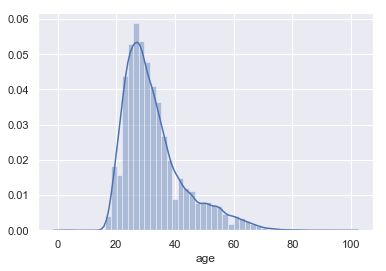

In [75]:
sns.distplot(agedist.astype("float"))

In [78]:
np.median(agedist.astype("float"))

30.0

Skews left, mostly people in their early 30s, with the median age being 30.

#### Lets see the happy  moments data 

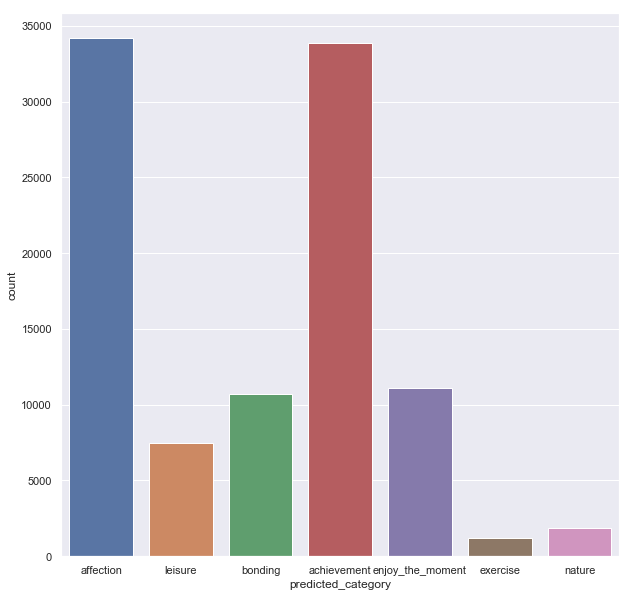

In [69]:
plt.figure(figsize = (10,10))
sns.countplot(x="predicted_category", data=data)

People don't appreciate the simple things more

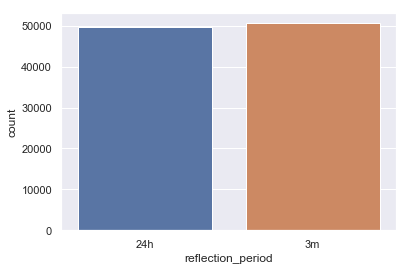

In [70]:
sns.countplot(x="reflection_period", data=data)

Even split, maybe checking to see if this leads to happier people in the future. Or if they post more.

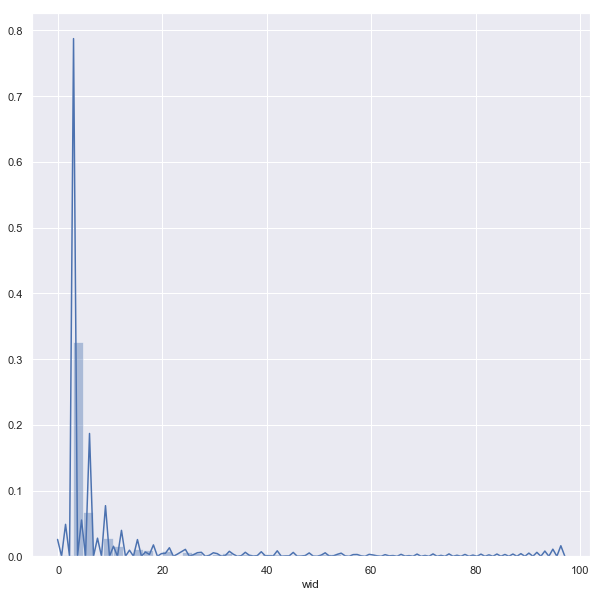

In [71]:
plt.figure(figsize = (10,10))
sns.distplot(data.wid.value_counts())

Majority of people only did 3 posts

#### What did they post?

In [10]:
df_hm = data[data['cleaned_hm'].notnull()]
len_count = df_hm['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100391.000000
mean         18.315327
std          21.484615
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

Skews left towards 0, likely in exponential decay. Max is substantially longer, similar to number of posts. May be a correlation to number of posts and average length of post.

In [11]:
data["cleaned_hm"][np.argmax(len_count)]

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


'My much awaited desired prolonged Velankanni trip.\r\n\r\nOne of the greatest pleasures of being in Chennai is your proximity to a lot of one day getawaysa| and nothing more exciting than planning a trip.\r\n\r\nEven though we are in the first quarter of the year I have exhausted my leaves due to our clichA(c) dialogue personal issuesa.\r\n\r\nNow that canat stop me from holidaying ;-)\r\n\r\nWhen I sat down to plan the places to visit on my bucket list the first one that popped up was Velankanni, to visit the shrine of lady of good health.\r\n\r\nIn times of sickness this was always on my mind that when I get back to optimum health I will go and stand face to face with this mother as a sign of gratitude.\r\n\r\nHailing from down south in Kerala the trips to Velankanni were often registered as tedious, dirty, long trips.\r\n\r\nI decided to create a better memory and enjoy my trip.\r\n\r\nI did my research on climate to start with, modes of transport, hotels food, mass timings, and ot

Just wanted to see who posted the largest entry. What about sentence data?

In [12]:
data.num_sentence.describe()

count    100391.000000
mean          1.341246
std           1.298024
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          69.000000
Name: num_sentence, dtype: float64

Pretty much useless. Almost all the values are 1 sentence long.

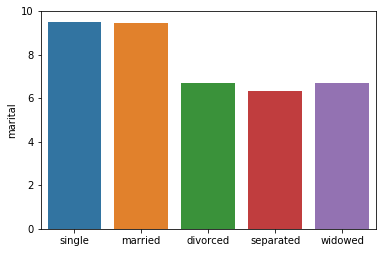

In [13]:
relationship_posts = data.marital.value_counts()/demo.marital.value_counts()
sns.barplot(x=relationship_posts.index, y=relationship_posts)

Single and Married people post more happy moments

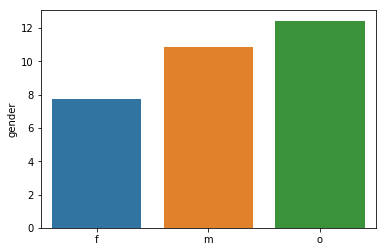

In [14]:
gender_posts = data.gender.value_counts()/demo.gender.value_counts()
sns.barplot(x=gender_posts.index, y=gender_posts)

Men post substantially more moments. People who identify as other seem to use it the most.

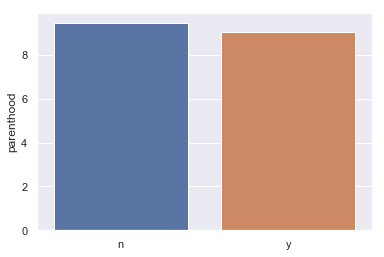

In [78]:
parenthood_posts = data.parenthood.value_counts()/demo.parenthood.value_counts()
sns.barplot(x=parenthood_posts.index, y=parenthood_posts)

Balanced data set

#### Let's used the processed data

In [15]:
all_words =  " ".join(word for word in data.text.astype(str))
print("The number of words is {}".format(len(all_words)))

The number of words is 4279205


#### Wordcloud

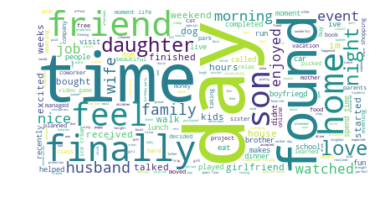

In [80]:
#from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator# Generate a word cloud image

wordcloud = WordCloud(background_color="white").generate(all_words)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looks like having time in the day, finding something lost, and kinship are the most referenced in the happy moments data. Let's dig deeper

#### Predicting classes based on words

In [8]:
gender_data = data[pd.notnull(data['gender'])]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

#get count vectors
counter = CountVectorizer()
processed_text = gender_data.text.dropna()
X = counter.fit_transform(processed_text)
y = np.asarray(gender_data.gender)

Naive Bayes
--------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           f       0.60      0.53      0.56     12486
           m       0.68      0.75      0.72     17395
           o       0.08      0.01      0.02       213

   micro avg       0.65      0.65      0.65     30094
   macro avg       0.45      0.43      0.43     30094
weighted avg       0.64      0.65      0.65     30094



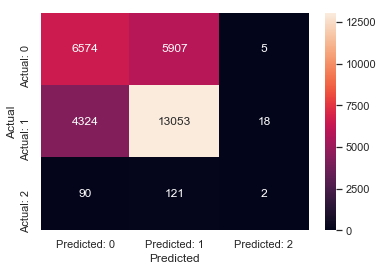

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression
--------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           f       0.63      0.46      0.53     12486
           m       0.67      0.81      0.73     17395
           o       1.00      0.00      0.01       213

   micro avg       0.66      0.66      0.66     30094
   macro avg       0.77      0.43      0.43     30094
weighted avg       0.66      0.66      0.65     30094



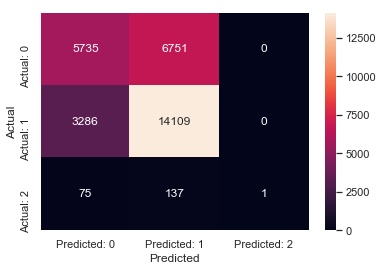

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 100)

nb = MultinomialNB().fit(X_train, y_train)
pred = nb.predict(X_test)
acc = nb.score(X_test, y_test)
#mean acc
print("Naive Bayes")
print("-"*50)
print('Classification Report \n', classification_report(y_test, pred))
#confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred), ['Actual: 0', 'Actual: 1', 'Actual: 2'], ['Predicted: 0', 'Predicted: 1', 'Predicted: 2'])
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('\n')

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
acc = lr.score(X_test, y_test)
#mean acc
print("Logistic Regression")
print("-"*50)
print('Classification Report \n', classification_report(y_test, pred))
#confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred), ['Actual: 0', 'Actual: 1', 'Actual: 2'], ['Predicted: 0', 'Predicted: 1', 'Predicted: 2'])
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We're really bad at predicting the "other" gender class. Let's see how scores change when I remove it

In [24]:
gender_data.gender.unique()

array(['m', 'f', 'o'], dtype=object)

Let's try it with idf

In [72]:
#tfidf of counts
tfidf_transformer = TfidfTransformer()
X_idf = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_idf, y, test_size = .3, random_state = 100)

"""
Naive Bayes
"""
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
acc = nb.score(X_test, y_test)
#mean acc
print("Naive Bayes")
print("-"*50)
print('Classification Report \n', classification_report(y_test, pred))
#confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)
#auc

"""
Logistic Regression
"""
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
acc = lr.score(X_test, y_test)
#mean acc
print("Logistic Regression")
print("-"*50)
print('Classification Report \n', classification_report(y_test, pred))
#confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

"""
SVM
"""
svm = LinearSVC()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
acc = svm.score(X_test, y_test)
#mean acc
print("SVM")
print("-"*50)
print('Classification Report \n', classification_report(y_test, pred))
#confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred), ['Actual: 0', 'Actual: 1'], ['Predicted: 0', 'Predicted: 1'])
print(cm)

Naive Bayes
--------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           f       0.67      0.37      0.48     12620
           m       0.65      0.87      0.75     17265

   micro avg       0.66      0.66      0.66     29885
   macro avg       0.66      0.62      0.61     29885
weighted avg       0.66      0.66      0.63     29885

           Predicted: 0  Predicted: 1
Actual: 0          4666          7954
Actual: 1          2284         14981


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression
--------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           f       0.65      0.45      0.53     12620
           m       0.67      0.82      0.74     17265

   micro avg       0.66      0.66      0.66     29885
   macro avg       0.66      0.64      0.63     29885
weighted avg       0.66      0.66      0.65     29885

           Predicted: 0  Predicted: 1
Actual: 0          5679          6941
Actual: 1          3089         14176
SVM
--------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           f       0.63      0.48      0.54     12620
           m       0.68      0.79      0.73     17265

   micro avg       0.66      0.66      0.66     29885
   macro avg       0.65      0.64      0.64     29885
weighted avg       0.65      0.66      0.65     29885

           Predicted: 0  Predicted: 1
Actual: 0          6

What things matter the most to people in each gender

In [73]:
num_words = 10 #top words
indices = np.argsort(lr.coef_[0])

#getting names and values of most commonly associated genders/words
feature_names = np.array(counter.get_feature_names())[indices] 
feature_values = np.array(lr.coef_[0])[indices]

print("Most common words from women")
print(feature_names[:num_words])
print("Most common words from men")
print(feature_names[-num_words:])

Most common words from women
['husband' 'boyfriend' 'blissful' 'makeup' 'precious' 'knitting' 'hubby'
 'grandson' 'purse' 'mth']
Most common words from men
['nba' 'girl' 'bike' 'golf' 'gf' 'football' 'beer' 'motorcycle'
 'girlfriend' 'wife']


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

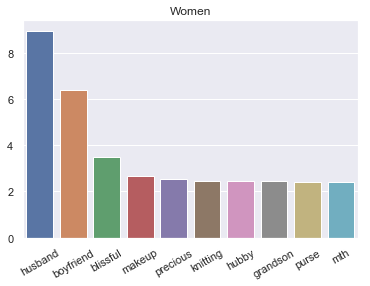

In [67]:
sns.barplot(x=feature_names[:num_words], y=np.abs(feature_values[:num_words]))
plt.title("Women")
plt.xticks(rotation=30)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

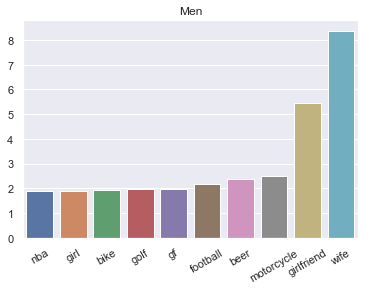

In [68]:
sns.barplot(x=feature_names[-num_words:], y=np.abs(feature_values[-num_words:]))
plt.title("Men")
plt.xticks(rotation=30)

## Let's do the rest of the data

Cleaning Data

In [26]:
toclassifydata = data[["reflection_period", "age", "country", "marital", "parenthood", "text"]]
toclassifydata.isnull().sum()

reflection_period      0
age                   93
country              203
marital              157
parenthood            78
text                   0
dtype: int64

Let's clean up each data set a bit

1. Age. Replace age text values with float values and remove any obviously wrong ages. (Done earlier when plotting distribution). Will be trying to classify if someone is above or below the age of 30, which is the median age of the writers.  
2. Country. Will be comparing to see USA vs the rest of the world. Otherwise too many other countries to compare to.  
3. Marital. Will be comparing single, married, and lost spouses(combining widowed, divorced, separated into a single data point).  
4. Parenthood. No changes  
5. Dropping all nan values right before comparison

In [27]:
# Age 
agedist = toclassifydata.age.replace(["prefer not to say", "2", "2.0", "3.0", "4", "čá", "233.0", "227", "nan"], pd.np.nan)
agedist = agedist.replace("60yrs", "60")
toclassifydata["age"] = agedist.astype("float")
#toclassifydata["age"] = pd.cut(toclassifydata["age"], bins = [0, 29, 49, 100],labels = ["18-29","29-49", "50+"])
# this was very bad at predicting 50+
toclassifydata["age"] = pd.cut(toclassifydata["age"], bins = [0, 29, 100],labels = ["-29","30+"])


# Country
toclassifydata.loc[(toclassifydata.country != "USA") & (toclassifydata.country.notnull()), "country"] = "Other"

# Marital
#toclassifydata.replace(["widowed", "divorced", "separated"], "lost spouse", inplace = True)
# lost spouse had really bad prediction rates
toclassifydata.replace(["widowed", "divorced", "separated"], "single", inplace = True)


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Importing pipeline to make it easier to run models

In [20]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

Accuracy: 0.69
Classification Report 
               precision    recall  f1-score   support

         24h       0.69      0.68      0.68     49746
          3m       0.69      0.69      0.69     50645

   micro avg       0.69      0.69      0.69    100391
   macro avg       0.69      0.69      0.69    100391
weighted avg       0.69      0.69      0.69    100391



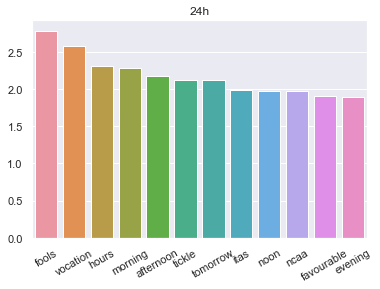

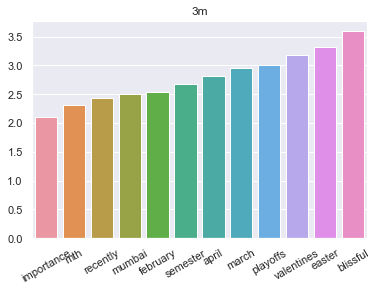

Accuracy: 0.68
Classification Report 
               precision    recall  f1-score   support

         -29       0.67      0.64      0.66     47856
         30+       0.68      0.72      0.70     52313

   micro avg       0.68      0.68      0.68    100169
   macro avg       0.68      0.68      0.68    100169
weighted avg       0.68      0.68      0.68    100169



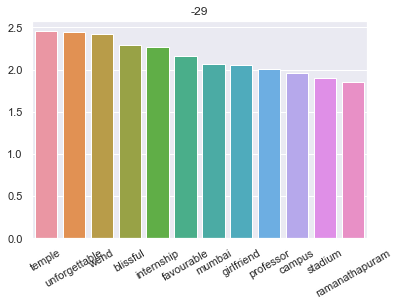

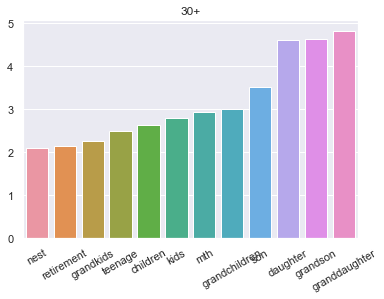

Accuracy: 0.87
Classification Report 
               precision    recall  f1-score   support

       Other       0.85      0.50      0.63     21247
         USA       0.88      0.98      0.92     78941

   micro avg       0.87      0.87      0.87    100188
   macro avg       0.86      0.74      0.78    100188
weighted avg       0.87      0.87      0.86    100188



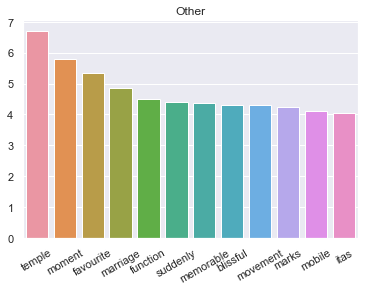

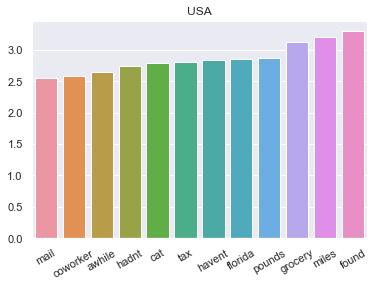

Accuracy: 0.73
Classification Report 
               precision    recall  f1-score   support

     married       0.77      0.48      0.59     41300
      single       0.71      0.90      0.80     58934

   micro avg       0.73      0.73      0.73    100234
   macro avg       0.74      0.69      0.69    100234
weighted avg       0.74      0.73      0.71    100234



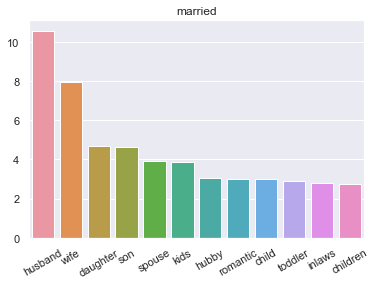

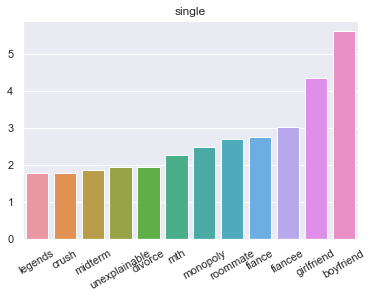

Accuracy: 0.74
Classification Report 
               precision    recall  f1-score   support

           n       0.72      0.93      0.81     60838
           y       0.80      0.44      0.57     39475

   micro avg       0.74      0.74      0.74    100313
   macro avg       0.76      0.69      0.69    100313
weighted avg       0.75      0.74      0.72    100313



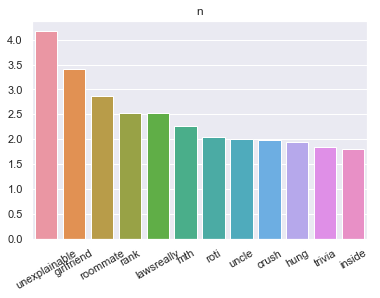

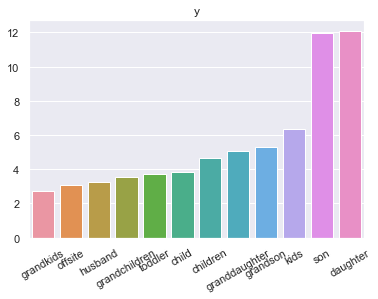

In [28]:
for column in toclassifydata:
    
    # remove na 
    temp_data = toclassifydata.dropna(subset = [column])
    X = temp_data["text"]
    y = temp_data[column]

    if (X.equals(y)):
        break
        
    # fit and score
    text_clf.fit(X, y)
    pred = text_clf.predict(X)
    print("Accuracy: {0:.2f}".format(np.mean(pred == y)))
    print('Classification Report \n', classification_report(y, pred))

    # define number of categories
    num_categories = len(text_clf.named_steps['clf'].coef_)

    # print accuracies and graphs
    
    # specific to two category classification
    if (num_categories == 1):
        # most important words
        num_words = 12 #top words
        indices = np.argsort(text_clf.named_steps['clf'].coef_[0])

        #getting names and values of most commonly associated words to category
        feature_names = np.array(text_clf.named_steps['vect'].get_feature_names())[indices] 
        feature_values = np.array(text_clf.named_steps['clf'].coef_[0])[indices]
        
        # plot both ends of coef 
        sns.barplot(x=feature_names[:num_words], y=np.abs(feature_values[:num_words]))
        plt.title("{}".format(text_clf.named_steps['clf'].classes_[0]))
        plt.xticks(rotation=30)
        plt.show()

        sns.barplot(x=feature_names[-num_words:], y=np.abs(feature_values[-num_words:]))
        plt.title("{}".format(text_clf.named_steps['clf'].classes_[1]))
        plt.xticks(rotation=30)
        plt.show()
        
#     # specific to muli-class classification
#     else:
#         for category in range(num_categories):
#             # most important words
#             num_words = 12 #top words
#             indices = np.argsort(text_clf.named_steps['clf'].coef_[category])

#             #getting names and values of most commonly associated genders/words
#             feature_names = np.array(text_clf.named_steps['vect'].get_feature_names())[indices] 
#             feature_values = np.array(text_clf.named_steps['clf'].coef_[category])[indices]

#             sns.barplot(x=feature_names[:num_words], y=np.abs(feature_values[:num_words]))
#             plt.title("{}".format(np.flip(text_clf.named_steps['clf'].classes_)[category]))
#             plt.xticks(rotation=30)
#             plt.show()